In [227]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.style.use(['dark_background'])

In [228]:
def date_time_parser(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

# Single Asset

In [229]:
ticker = "spy"
df = pd.read_csv(f'../data/ETFs/{ticker}.us.txt', header=0, parse_dates=[0], date_parser=date_time_parser)

In [230]:
df.index = df['Date']

In [231]:
df.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,,
2005-02-25,2005-02-25,104.77,106.00,104.68,105.79,70221808,0
2005-02-28,2005-02-28,105.55,105.68,104.56,105.08,79695344,0
2005-03-01,2005-03-01,105.22,105.87,105.22,105.62,54607412,0
2005-03-02,2005-03-02,105.21,106.22,105.10,105.57,73733090,0
2005-03-03,2005-03-03,105.99,106.20,105.15,105.61,71286823,0
2005-03-04,2005-03-04,106.31,107.01,106.10,106.93,64483624,0
2005-03-07,2005-03-07,106.86,107.38,106.62,106.97,50288014,0
2005-03-08,2005-03-08,106.87,107.15,106.36,106.55,51274973,0
2005-03-09,2005-03-09,106.25,106.52,105.38,105.39,84491113,0


In [232]:
#Calculate log returns
price = df['Close']
log_rs = price.apply(np.log).diff(1).fillna(0)

In [233]:
# short-term moving average window - long-term moving average window
w1 = 5
w2 = 22
ma_x = price.rolling(w1).mean() - price.rolling(w2).mean()

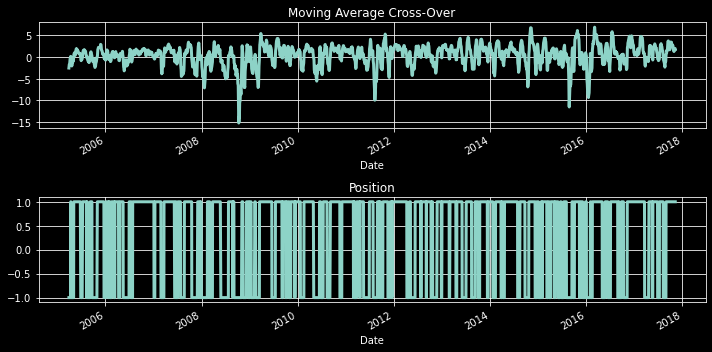

In [234]:
# translate the signal to trading positions
trade_position = ma_x.apply(np.sign)

fig, ax = plt.subplots(2,1)
ma_x.plot(ax=ax[0], title='Moving Average Cross-Over')
trade_position.plot(ax=ax[1], title='Position')
plt.show()

In [235]:
my_returns = trade_position.shift(1)*log_rs #shift 

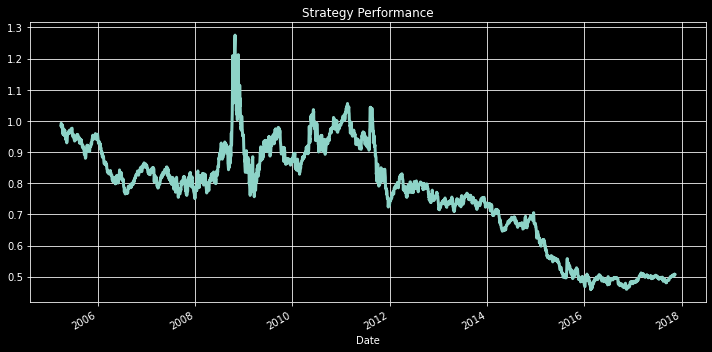

In [236]:
my_returns.cumsum().apply(np.exp).plot(title="Strategy Performance")

# Multiasset

In [237]:
tickers = ['gcc', 'spy', 'tipx']

In [259]:
dfs = []
date_range = []
for ticker in tickers:
    df = pd.read_csv(f"../data/ETFs/{ticker}.us.txt",  header=0, parse_dates=[0], date_parser=date_time_parser, usecols=['Date', 'Close'])
    date_range.append((min(df["Date"]), max(df["Date"])))
    df.index = df["Date"]
    df.rename(columns={"Date": f"Date_{ticker}", "Close": f"Close_{ticker}"}, inplace=True)
    dfs.append(df)
df = pd.concat(dfs, axis=1)

In [260]:
latest_start_date = max([o[0] for o in date_range])
earliest_end_date = min([o[1] for o in date_range])

In [261]:
tmp_dfs = []
for ticker in tickers:
    slice_df = df[(df.index > latest_start_date) & (df.index < earliest_end_date)]
    
    tmp_dfs.append(slice_df[f"Close_{ticker}"])

In [262]:
train_df = pd.concat(tmp_dfs, axis=1)

In [263]:
train_df.fillna(method="ffill", inplace=True)

In [267]:
log_rs = train_df.apply(np.log).diff(1).fillna(0)

In [270]:
w1 = 5
w2 = 22
ma_x = train_df.rolling(w1).mean() - train_df.rolling(w2).mean()

In [271]:
ma_x

,Close_gcc,Close_spy,Close_tipx
Date,,,
2013-06-06,NaN,NaN,NaN
2013-06-07,NaN,NaN,NaN
2013-06-10,NaN,NaN,NaN
2013-06-11,NaN,NaN,NaN
2013-06-12,NaN,NaN,NaN
...,...,...,...
2017-11-03,0.151688,1.562818,0.032045
2017-11-06,0.170870,1.792364,0.039136
2017-11-07,0.195506,1.900909,0.048136


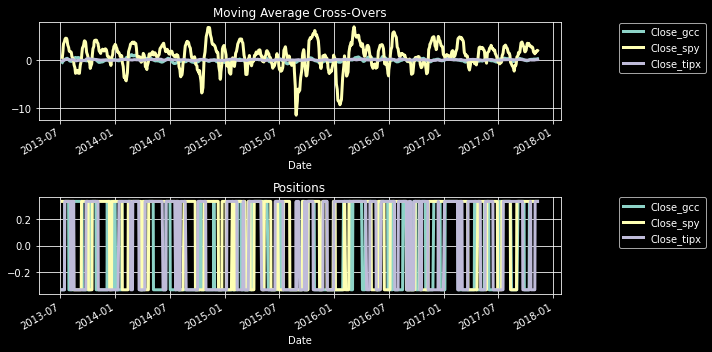

In [272]:
pos = ma_x.apply(np.sign)
pos /= pos.abs().sum(1).values.reshape(-1,1)

fig, ax = plt.subplots(2,1)
ma_x.plot(ax=ax[0], title='Moving Average Cross-Overs')
ax[0].legend(bbox_to_anchor=(1.1, 1.05))
pos.plot(ax=ax[1], title='Positions')
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('tmp.png')

In [273]:
my_returns = pos.shift(1)*log_rs #shift 

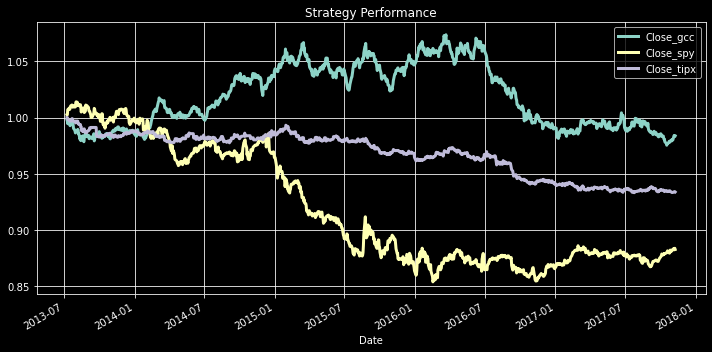

In [274]:
my_returns.cumsum().apply(np.exp).plot(title="Strategy Performance")

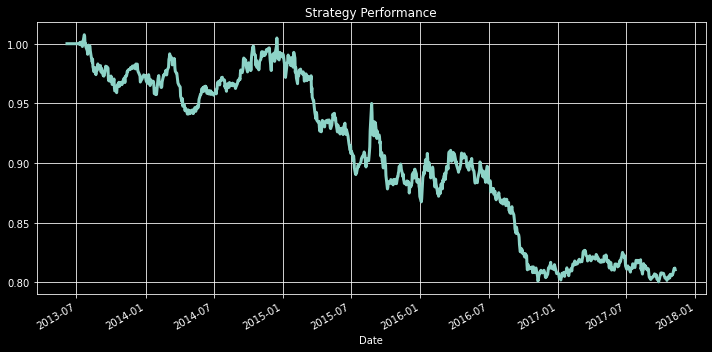

In [275]:
my_returns = (pos.shift(1)*rs).sum(1)

my_returns.cumsum().apply(np.exp).plot(title='Strategy Performance')

# Look ahead bias performance

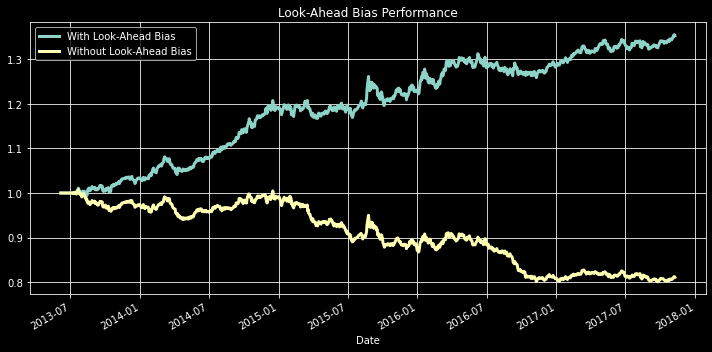

In [276]:
my_rs1 = (pos*rs).sum(1)
my_rs2 = (pos.shift(1)*rs).sum(1)

my_rs1.cumsum().apply(np.exp).plot(title='Look-Ahead Bias Performance')
my_rs2.cumsum().apply(np.exp).plot()
plt.legend(['With Look-Ahead Bias', 'Without Look-Ahead Bias'])
# rs.mean(1).cumsum().apply(np.exp).plot()
# plt.legend(['my performance', 'benchmark performance'])
plt.savefig('tmp.png')